In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from imblearn.over_sampling import SMOTE as smote
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTETomek

from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, roc_curve, auc, average_precision_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# Parse Data

In [2]:
df = pd.read_csv('assignment-data/data_for_student_case.csv', dtype={'bin':str, 'amount':int}, na_filter=False)
df = df.drop(['txid','bookingdate'], axis='columns')  # We are not interested in these columns (using booking date would be cheating)
df = df.rename(index=str, columns={'issuercountrycode':'issuercountry', 
                                   'bin':'issuer_id', 
                                   'shoppercountrycode':'shoppercountry', 
                                   'shopperinteraction':'interaction', 
                                   'cardverificationcodesupplied':'verification', 
                                   'cvcresponsecode':'cvcresponse', 
                                   'creationdate':'creationdate_stamp', 
                                   'simple_journal':'label'})  # Use column names which are more recognizable

# Skip data if:
df = df[df['label']!='Refused']
df = df[~df['issuer_id'].str.contains('na', case=False)]
df = df[~df['mail_id'].str.contains('na', case=False)]

# Create and format (new) columns
df['creationdate'] = (pd.to_datetime(df['creationdate_stamp'])).dt.date
df['issuer_id'] = pd.to_numeric(df['issuer_id'])
df['mail_id'] = pd.to_numeric(df['mail_id'].str.replace('email','')).astype(int)
df['ip_id'] = pd.to_numeric(df['ip_id'].str.replace('ip','')).astype(int)
df['card_id'] = pd.to_numeric(df['card_id'].str.replace('card','')).astype(int)
df['subscription'] = pd.to_numeric(df['interaction'].apply(lambda x: '1' if x == 'ContAuth' else '0'))
df['verification'] = pd.to_numeric(df['verification'].apply(lambda x: '1' if x else '0'))

# Label the data
df['label'] = pd.to_numeric(df['label'].apply(lambda x: '1' if x == 'Chargeback' else '0'))

df.loc[df['shoppercountry'] == df['issuercountry'], 'home_country'] = 1
df.loc[df['shoppercountry'] != df['issuercountry'], 'home_country'] = 0

# Preprocess Data

In [3]:
converter = {
    'AUD': 0.702495,
    'GBP': 1.305505,
    'MXN': 0.05274,
    'NZD': 0.6632,
    'SEK': 0.104965
}


# Function that can take two input values (amount, currency) and convert it to USD (using current ratios, not historic ones)
def convert_to_usd(args):
    amount, currency = args
    return converter[currency] * amount / 100

# Create a new column containing the transaction amount in USD to be able to compare the transaction amounts.
df['usd_amount'] = df[['amount', 'currencycode']].apply(convert_to_usd, axis=1)

# Create new dataframe with average expense per customer
avg_expense = df.groupby('card_id')['usd_amount'].mean().reset_index().rename(columns={'usd_amount': 'avg_amount'})
# Merge this new dataframe with our parsed dataset to obtain a column with average amounts
df = pd.merge(df, avg_expense, on='card_id', how='left')
# We are actually mainly interested in the difference between 
# the average transaction amount of this customer and the current transaction amount.
df['dif_avg_amount'] = df['usd_amount'] - df['avg_amount']

# Number of transactions in this country
ntc = df.groupby(['card_id', 'shoppercountry'])['amount'].agg(['count']).reset_index().rename(columns={'count': 'ntc'})
df = pd.merge(df, ntc, on=['card_id', 'shoppercountry'], how='left')

# Number of transactions for this interaction type
nti = df.groupby(['card_id', 'interaction'])['amount'].agg(['count']).reset_index().rename(columns={'count': 'nti'})
df = pd.merge(df, nti, on=['card_id', 'interaction'], how='left')

In [4]:
print("Total amount:", len(df))
fraud = df[df['label']==1]
benign = df[df['label']==0]

Total amount: 236698


# Find interesting relationships in the data

In [5]:
number_of_fraudulent_cases = len(fraud)
print("Number of fraudulent cases:", number_of_fraudulent_cases)

number_of_benign_cases = len(benign)
print("Number of benign cases:", number_of_benign_cases)

Number of fraudulent cases: 345
Number of benign cases: 236353


In [6]:
not_same_country_benign = benign[benign['home_country'] != 1]
not_same_country_fraud = fraud[fraud['home_country'] != 1]
print("Fraction of benign data not in home country", len(not_same_country_benign) / len(benign))
print("Fraction of fraud data not in home country", len(not_same_country_fraud) / len(fraud))

Fraction of benign data not in home country 0.02904976877805655
Fraction of fraud data not in home country 0.04057971014492753


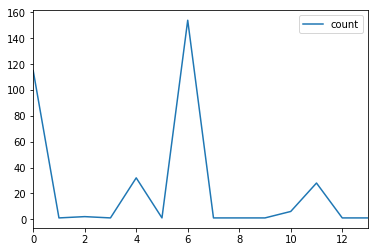

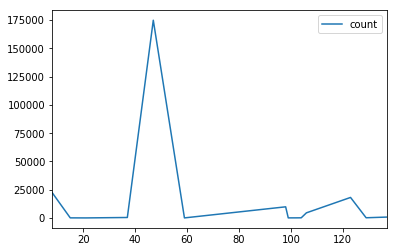

In [7]:
# The raw amounts from the fraud/benign transactions per country were further 
# processed in libre office to produce the graphs contained in the report (due to bug in pandas for python < 3.7).
amount_fraud_per_country = fraud.groupby('shoppercountry')['amount'].agg(['count']).reset_index()
fraudulent_countries = list(amount_fraud_per_country['shoppercountry'])
amount_fraud_per_country.plot()

amount_benign_per_country = benign.groupby('shoppercountry')['amount'].agg(['count']).reset_index()
amount_benign_per_country = amount_benign_per_country[pd.DataFrame(amount_benign_per_country.shoppercountry.tolist()).isin(fraudulent_countries).any(1)]
amount_benign_per_country.plot()

In [8]:
# Calculate average transaction amounts.
avg_usd_amount_fraud = fraud['usd_amount'].mean()
avg_usd_amount_benign = benign['usd_amount'].mean()
print("Average amount in USD for the fraudulent cases:", round(avg_usd_amount_fraud, 2))
print("Average amount in USD for the benign cases:", round(avg_usd_amount_benign, 2))

Average amount in USD for the fraudulent cases: 162.81
Average amount in USD for the benign cases: 87.06


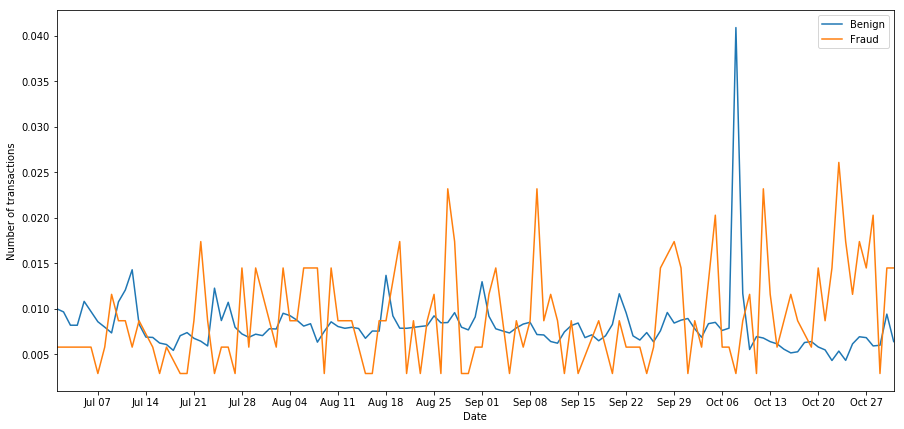

In [9]:
# Plot the fraction of fraudulent/benign transactions per day
d_benign = benign.groupby('creationdate')['amount'].agg(['count']).rename(columns={'count': 'Benign'})
d_benign['Benign'] = d_benign['Benign'] / len(benign)
d_fraud = fraud.groupby('creationdate')['amount'].agg(['count']).rename(columns={'count': 'Fraud'})
d_fraud['Fraud'] = d_fraud['Fraud'] / len(fraud)

plt.figure(1, figsize=(15,7))
fig = plt.gcf()
ax = plt.gca()

d_benign.plot(ax=ax)
d_fraud.plot(ax=ax)
ax.set(xlabel="Date", ylabel="Number of transactions")
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
# plt.savefig("transactions_per_day.png")
# plt.show()

# Compare sampling methods using ROC and AUC

In [10]:
def compare_sampling(classifier, classifier_name, sampling_name, train_ft, train_ft_smote, test_ft, train_lbl, train_lbl_smote, test_lbl):
    fig = plt.figure()
    
    plot_line_compare_sampling(classifier, classifier_name, 'normal', train_ft, test_ft, train_lbl, test_lbl)
    plot_line_compare_sampling(classifier, classifier_name, sampling_name, train_ft_smote, test_ft, train_lbl_smote, test_lbl)
    
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curves of %s and no %s for a %s' % (sampling_name, sampling_name, classifier_name))
    plt.legend(loc="lower right")
    plt.savefig(f'{sampling_name}_{classifier_name}.png')
    plt.show()
    return classifier
    
def plot_line_compare_sampling(classifier, classifier_name, line_label, train_ft, test_ft, train_lbl, test_lbl):
    classifier.fit(train_ft, train_lbl)
    
    predict_lbl = classifier.predict_proba(test_ft)
    predict_lbl = predict_lbl[:, 1]
    
    predict_decision_lbl = classifier.predict(test_ft)
    print(line_label+':')
    print(confusion_matrix(test_lbl, predict_decision_lbl))
    
    fp_rate, tp_rate, _ = roc_curve(test_lbl, predict_lbl, pos_label =True)
    area = auc(fp_rate, tp_rate)
    plt.plot(fp_rate, tp_rate, label=('ROC %s (area = %0.2f)') %(line_label, area))
    
    if classifier_name == "Decision Tree":
        export_graphviz(classifier, out_file='tree_%s.dot' %(line_label))   
    

In [11]:
def try_sampling(sampler, sampler_name):
    features_to_use = ['usd_amount', 'dif_avg_amount', 'ntc', 'home_country', 'cvcresponse', 'verification']
    data_ft = df[features_to_use].values
    data_lbl = df[['label']].values.ravel()

    train_ft, test_ft, train_lbl, test_lbl = train_test_split(data_ft,data_lbl,test_size=0.2)
    train_ft_smote, train_lbl_smote = sampler.fit_sample(train_ft,train_lbl)

    cl1 = compare_sampling(DecisionTreeClassifier(max_depth=4), "Decision Tree", sampler_name, train_ft, train_ft_smote, test_ft, train_lbl, train_lbl_smote, test_lbl)
    cl2 = compare_sampling(RandomForestClassifier(n_estimators=10), "Random Forest", sampler_name, train_ft, train_ft_smote, test_ft, train_lbl, train_lbl_smote, test_lbl)
    cl3 = compare_sampling(GaussianNB(), "Gaussian Naive Bayes", sampler_name, train_ft, train_ft_smote, test_ft, train_lbl, train_lbl_smote, test_lbl)
    cl4 = compare_sampling(AdaBoostClassifier(), "Ada Boost", sampler_name, train_ft, train_ft_smote, test_ft, train_lbl, train_lbl_smote, test_lbl)
    cl5 = compare_sampling(GradientBoostingClassifier(), "Gradient Boosting", sampler_name, train_ft, train_ft_smote, test_ft, train_lbl, train_lbl_smote, test_lbl)
#     cl6 = compare_sampling(VotingClassifier([cl1, cl2, cl3, cl4, cl5], method='all'), "Gradient Boosting", sampler_name, train_ft, train_ft_smote, test_ft, train_lbl, train_lbl_smote, test_lbl)
    

In [12]:
def train_clf(classifier, classifier_name, train_ft, test_ft, train_lbl, test_lbl):
    classifier.fit(train_ft, train_lbl)
    predict_decision_lbl = classifier.predict(test_ft)
    print(classifier_name +':')
    print(confusion_matrix(test_lbl, predict_decision_lbl))
    return classifier
    
data_ft = df[['usd_amount', 'dif_avg_amount', 'ntc', 'home_country', 'cvcresponse', 'verification']].values
data_lbl = df[['label']].values.ravel()
train_ft, test_ft, train_lbl, test_lbl = train_test_split(data_ft,data_lbl,test_size=0.2)
sampler = smote(sampling_strategy = 'minority')
train_ft_smote, train_lbl_smote = sampler.fit_sample(train_ft,train_lbl)

# sampler = SMOTETomek(ratio = 'auto')
# train_ft_smote_t, train_lbl_smote_t = sampler.fit_sample(train_ft,train_lbl)

cl1 = train_clf(DecisionTreeClassifier(max_depth = 4), "Decision Tree", train_ft_smote, test_ft, train_lbl_smote, test_lbl)
cl2 = train_clf(RandomForestClassifier(n_estimators=10), "Random Forest", train_ft_smote, test_ft, train_lbl_smote, test_lbl)
cl3 = train_clf(GaussianNB(), "Gaussian Naive Bayes", train_ft, test_ft, train_lbl, test_lbl)
cl4 = train_clf(VotingClassifier(estimators=[('DTC', cl1), ('RFC', cl2), ('GNBC', cl3)], voting='hard'), 
                'Voting',train_ft, test_ft, train_lbl, test_lbl)


Decision Tree:
[[38789  8484]
 [    7    60]]
Random Forest:
[[46271  1002]
 [   44    23]]
Gaussian Naive Bayes:
[[46855   418]
 [   59     8]]
Voting:
[[47267     6]
 [   66     1]]


# SMOTE

normal:
[[47284     0]
 [   56     0]]
SMOTE:
[[39681  7603]
 [    8    48]]


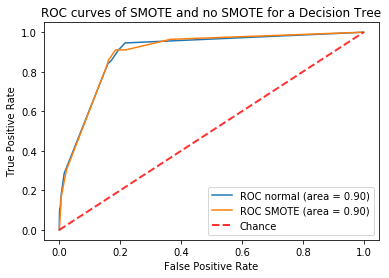

normal:
[[47267    17]
 [   54     2]]
SMOTE:
[[46322   962]
 [   37    19]]


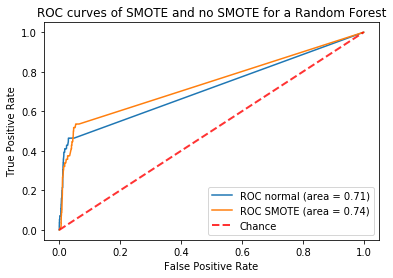

normal:
[[47090   194]
 [   49     7]]
SMOTE:
[[39135  8149]
 [    8    48]]


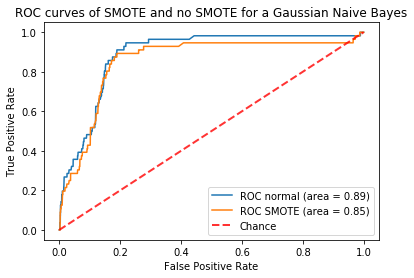

normal:
[[47283     1]
 [   56     0]]
SMOTE:
[[40505  6779]
 [   13    43]]


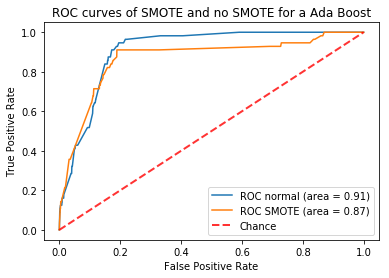

normal:
[[47278     6]
 [   56     0]]
SMOTE:
[[40894  6390]
 [   10    46]]


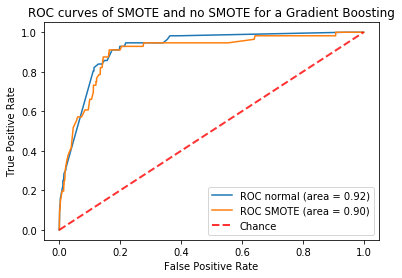

In [13]:
sm = smote(sampling_strategy = 'minority')
try_sampling(sm, 'SMOTE')

In [14]:
# tl = TomekLinks(ratio='majority')
# try_sampling(tl, 'Tomek Links')

In [15]:
# smt = SMOTETomek(ratio='auto')
# try_sampling(smt, 'SMOTE + Tomek Links')

normal:
[[47277     1]
 [   62     0]]
Random Under Sampling:
[[39119  8159]
 [    8    54]]


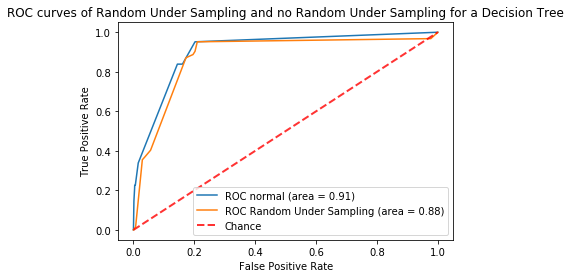

normal:
[[47267    11]
 [   59     3]]
Random Under Sampling:
[[39435  7843]
 [    6    56]]


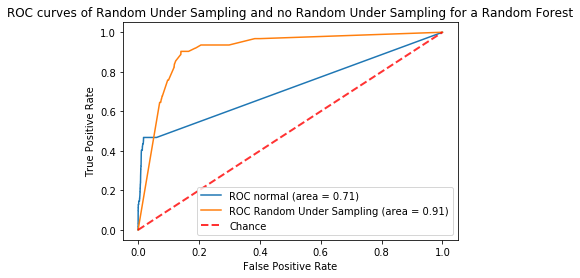

normal:
[[46869   409]
 [   55     7]]
Random Under Sampling:
[[36136 11142]
 [    2    60]]


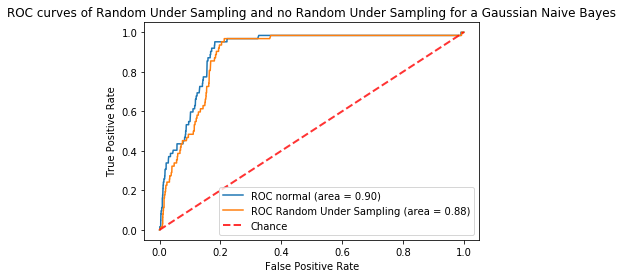

normal:
[[47273     5]
 [   62     0]]
Random Under Sampling:
[[38212  9066]
 [    7    55]]


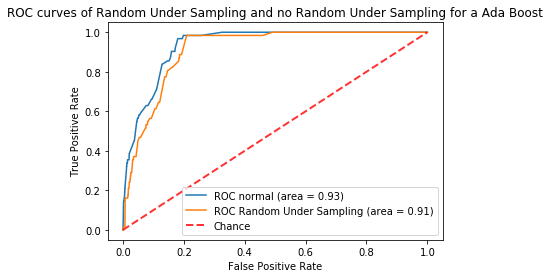

normal:
[[47272     6]
 [   62     0]]
Random Under Sampling:
[[38818  8460]
 [    4    58]]


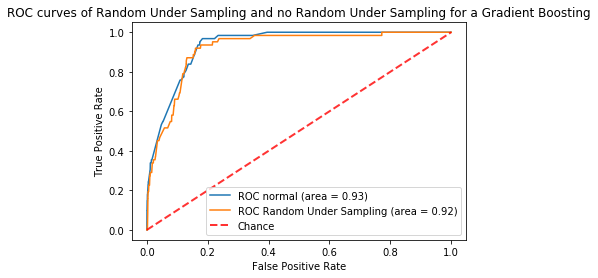

In [16]:
rus = RandomUnderSampler()
try_sampling(rus, 'Random Under Sampling')

[[234245   2108]
 [   308     37]]


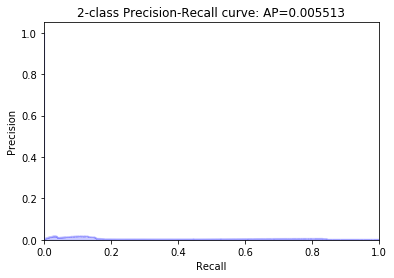

In [17]:
data_ft = df[['usd_amount', 'dif_avg_amount', 'ntc', 'home_country', 'cvcresponse', 'verification']].values
data_lbl = df[['label']].values.ravel()

# clf = RandomForestClassifier(n_estimators=10)
clf = GaussianNB()

decision_lbl = cross_val_predict(clf, data_ft, data_lbl, cv=10)
conf_mat = confusion_matrix(data_lbl, decision_lbl)
print(conf_mat)

predict_lbl = cross_val_predict(clf, data_ft, data_lbl, cv=10, method='predict_proba')[:,1]
average_precision = average_precision_score(data_lbl, predict_lbl)
precision, recall, _ = precision_recall_curve(data_lbl, predict_lbl)

fig = plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP=%f' %(average_precision))
plt.show()

# Task 3 - Processing data - K-folding - Precision Recall Curve

## Parsing data

In [13]:
#Parse CSV file
data = pd.read_csv('assignment-data/data_for_student_case.csv', dtype={'bin':str, 'amount':int}, na_filter=False)

# Skip data if:
data = data[data['simple_journal']!='Refused']
data = data[~data['bin'].str.contains('na', case=False)]
data = data[~data['mail_id'].str.contains('na', case=False)]

# Filter on columns
data = data[['card_id', 'issuercountrycode', 'shoppercountrycode', 'cardverificationcodesupplied', 'cvcresponsecode', 'simple_journal', 'amount', 'shopperinteraction', 'currencycode']]

# Rename some columns
data = data.rename(index=str, columns={'issuercountrycode':'issuercountry', 
                                       'shoppercountrycode':'shoppercountry', 
                                       'cardverificationcodesupplied':'verification', 
                                       'cvcresponsecode':'cvcresponse', 
                                       'shopperinteraction' : 'interaction', 
                                       'simple_journal':'label'})

# Parse data to new types
data['card_id'] = pd.to_numeric(data['card_id'].str.replace('card','')).astype(int)
data['subscription'] = pd.to_numeric(data['interaction'].apply(lambda x: '1' if x == 'ContAuth' else '0'))
data['verification'] = pd.to_numeric(data['verification'].apply(lambda x: '1' if x else '0'))
data['label'] = pd.to_numeric(data['label'].apply(lambda x: '1' if x == 'Chargeback' else '0'))

## Preprocess data

In [14]:
# creating new features that are indepentent of time and other transaction

# Check if issuercountry and shoppercountry are equal
data.loc[data['shoppercountry'] == data['issuercountry'], 'home_country'] = 1
data.loc[data['shoppercountry'] != data['issuercountry'], 'home_country'] = 0

# Dollar conversion rate
converter = {
    'AUD': 0.702495,
    'GBP': 1.305505,
    'MXN': 0.05274,
    'NZD': 0.6632,
    'SEK': 0.104965
}

# Function that can take two input values (amount, currency) and convert it to USD (using current ratios, not historic ones)
def convert_to_usd(args):
    amount, currency = args
    return converter[currency] * amount / 100

# Create a new column containing the transaction amount in USD to be able to compare the transaction amounts.
data['usd_amount'] = data[['amount', 'currencycode']].apply(convert_to_usd, axis=1)

## KFold method that makes PR-curve as well

In [34]:
def KFold_PRC(data, folds, classifier,sampling=None):
    kf = KFold(n_splits = folds, shuffle = True)

    prob_lbl = []
    decision_lbl = []
    original_lbl = []

    for i_train, i_test in kf.split(data):
        train_ft = data.iloc[i_train].drop(columns = ['label'])
        test_ft =  data.iloc[i_test].drop(columns = ['label'])
        train_lbl = data.iloc[i_train]['label']
        test_lbl = data.iloc[i_test]['label']
        
        train_ft, test_ft = calculate_features(train_ft, test_ft)

        if sampling:
            train_ft_sample, train_lbl_sample = sampling.fit_sample(train_ft,train_lbl)
            classifier.fit(train_ft_sample, train_lbl_sample)
        else:
            classifier.fit(train_ft, train_lbl)

        decision_lbl.extend(classifier.predict(test_ft))
        prob_lbl.extend(classifier.predict_proba(test_ft)[:,1])
        original_lbl.extend(test_lbl)


    average_precision = average_precision_score(original_lbl, prob_lbl)
    precision, recall, _ = precision_recall_curve(original_lbl, prob_lbl)
    
    cm = confusion_matrix(original_lbl, decision_lbl)
    print(cm)

    fig = plt.figure()
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP=%f' %(average_precision))
    plt.show()

## In-process data aggregation method

In [44]:
def calculate_features(data_train, data_test):
    #calculate average expense per card and overall based on training set
    avg_expense = data_train.groupby('card_id')['usd_amount'].mean().reset_index().rename(columns={'usd_amount': 'avg_amount'})
    avg_expense_overall = data_train['usd_amount'].mean()
    
    # Merge avarages with training and test set (test set has no influence on training set this way)
    data_train = pd.merge(data_train, avg_expense, on='card_id', how='left')
    data_test = pd.merge(data_test, avg_expense, on='card_id', how='left')
    data_test['avg_amount'].fillna(avg_expense_overall, inplace=True)
    
    # Calculate difference between avarages and expenses for training and test set
    data_train['dif_avg_amount'] = data_train['usd_amount'] - data_train['avg_amount']
    data_test['dif_avg_amount'] = data_test['usd_amount'] - data_test['avg_amount']
    
    # Number of transactions in this country based on training set
    ntc = data_train.groupby(['card_id', 'shoppercountry'])['usd_amount'].agg(['count']).reset_index().rename(columns={'count': 'ntc'})
    ntc_overall = data_train.groupby(['shoppercountry', 'card_id'])['usd_amount'].agg(['count'])
    ntc_overall = ntc_overall.groupby(['shoppercountry'])['count'].mean()
    
    # Merge numer of transactions per country with training and test set (test set has no influence on training set this way)
    data_train = pd.merge(data_train, ntc, on=['card_id', 'shoppercountry'], how='left')
    data_test = pd.merge(data_test, ntc, on=['card_id', 'shoppercountry'], how='left')
    data_test['ntc'].fillna(0, inplace=True)
    
    # Drop unnassesary collumns
    data_train.drop(columns = ['card_id', 'shoppercountry'], inplace=True)
    data_test.drop(columns = ['card_id', 'shoppercountry'], inplace=True)
    
    # Final set for training consits of following features:
    # usd_amount, home_country, cvcresponse, verification, avg_amount, dif_avg_amount, ntc
    
    return data_train, data_test

## Call KFolding using specified settings

[[236009    344]
 [   337      8]]


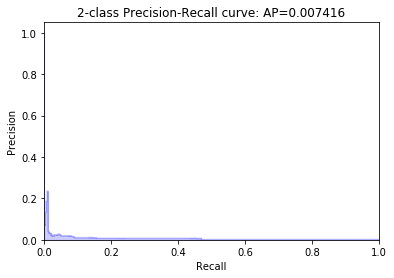

In [46]:
#Data selection should contain: label, shoppercountry, usd_amount, card_id for in-process data aggregation
data_selection = data[['label', 'card_id', 'usd_amount', 'shoppercountry', 'home_country', 'cvcresponse', 'verification']]

classifier = RandomForestClassifier(n_estimators=10)
sm = smote(sampling_strategy = 'minority')
KFold_PRC(data_selection, 10, classifier, sm)

# classifier = GaussianNB()

# classifier = MLPClassifier(hidden_layer_sizes=(10,10), max_iter=15, verbose=True)
# KFold_PRC(data_selection, 10, classifier)

